# COMSOL Simulation of the emitting spot size

- Original datafile in: /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/2018-10-23_comsol/particleData/current_target.1mA.0.15eV.2.5e7.80kV.13mmExtr.particleData.csv

- Settings in COMSOL were: -80 kV, 1mA ion beam current

- Script to generate the original plot: 02_PhD/01.github/phd/03_COMSOL/03_BeamOptics/01_particlePosition/2018-11-21.particleData.singleFile.lastTimestep.IEEE_NSS_Conference.py


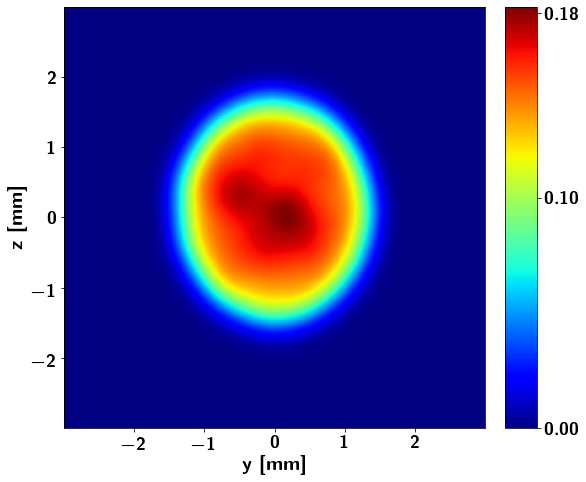

In [4]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import kde
from scipy import optimize
from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

pd.set_option("display.max_columns", 300)
outfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/COMSOL_ion_beam/'
figname = 'COMSOL_FWHM_kde'

# filename for the data
# fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/2018-10-23_comsol/particleData/plots/2D_histograms_lastTimestep/IEEE_NSScurrent_target.1mA.0.15eV.2.5e7.80kV.13mmExtr.particleData/current_target.1mA.0.15eV.2.5e7.80kV.13mmExtr.particleData.csv_df_histData.csv'
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/2018-10-23_comsol/particleData/plots/2D_histograms_lastTimestep/current_target.1mA.0.15eV.2.5e7.80kV.12mmExtr.particleData.csv_df_histData.csv'

data = pd.read_csv(fname, index_col=0)

nbins = 300
lim = 3
x = data['qy'].values
y = data['qz'].values
my_data = np.vstack([x, y])
k = kde.gaussian_kde(my_data)

xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# zi = zi/np.max(zi)
# plot
fs = 20

f = plt.figure(1, figsize=(9, 9))

nullfmt = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
rect_scatter = [left, bottom, width, height]
axScatter = plt.axes(rect_scatter)
p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
plt.axis('equal')
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
axScatter.tick_params('x', colors='black', labelsize=fs-2)
axScatter.tick_params('y', colors='black', labelsize=fs-2)
plt.yticks(np.arange(-2,3,1))
plt.xticks(np.arange(-2,3,1))


left = 0.8
bottom = 0.12
width = 0.05
height = 0.65
cax = f.add_axes([left, bottom, width, height])
cbar = f.colorbar(p, cax, ticks=[0,0.1,0.18])

cbar.ax.tick_params(labelsize=fs-2)
plt.savefig(f'{outfolder}{figname}.pdf')

plt.show()

In [2]:
np.max(zi)

0.1829177016678319

## Plot along y=0 and y=0

In [3]:
outfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/COMSOL_ion_beam/'
figname = 'COMSOL_FWHM_fits_2'

# query from the estimated pdf
qry_eval = np.linspace(-lim,lim,100)
eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

# fit FWHM
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))


p0 = [1, 1, 1] # Initial guess for the parameters
# fit for parallel to x axis
X = qry_eval
Y = eval_x
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_x, x0_x, sigma_x = popt
Y_fit_x = gauss(X, *popt)
FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in x: {FWHM_x}')

# fit for parallel to y axis
X = qry_eval
Y = eval_y
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_y, x0_y, sigma_y = popt
FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in y: {FWHM_y}')
Y_fit_y = gauss(X, *popt)
print(gauss(x0_y, *popt), A_y)

f = plt.figure(1, figsize=(8, 6.4))
ylims = (-0.01, 0.20)
# top plot
plt.subplot(2, 1, 1)
plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
plt.text(-0.5, .12, r'\textbf{FWHM = 2.14 mm}', fontsize=14)
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-2,3,1))
leg1 = plt.legend(loc="best",  fontsize=12)
plt.ylim(ylims)
# bottom plot
plt.subplot(2, 1, 2)
plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
plt.text(-0.5, .12, r'\textbf{FWHM = 2.60 mm}', fontsize=14)
plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-2,3,1))
leg1 = plt.legend(loc="best",  fontsize=12)
# leg1.set_title(r"Experiment number", prop = {'size': 12})
plt.tight_layout()
plt.ylim(ylims)
plt.savefig(f'{outfolder}{figname}.pdf')
plt.show()

NameError: name 'curve_fit' is not defined

In [ ]:
gauss(FWHM_y/2,A_y, x0_y, sigma_y)